In [50]:
import torch
import torch.nn as nn

# Model

In [51]:
import torch
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F




class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

In [52]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Loading Pretrained model

In [53]:
transformer = TransformerNet().to('cpu')
transformer.load_state_dict(torch.load('/home/govind/dashot/model/0.pth',map_location=torch.device('cpu')))
transformer.eval()

TransformerNet(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((4, 4, 4, 4))
        (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
      )
      (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (3): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (block): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            

In [54]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [55]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
from PIL import Image
import os
import numpy as np

transforms_ = [
    transforms.Resize((256,256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]
transform = transforms.Compose(transforms_)

# Loading Test Image

In [62]:
test_image=Image.open('/home/govind/Govind/New_data_content/2007_000187.jpg')
test_image=transform_(test_image)
test_image=test_image.unsqueeze(0)


In [63]:
op=tfnet.forward(test_image)
op.shape

torch.Size([1, 3, 256, 256])

In [64]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


In [65]:
op_image=denormalize(op)
test_image=denormalize(test_image)
test_image=test_image.squeeze().permute(1,2,0).detach().cpu().numpy()
op_image=op.squeeze().permute(1,2,0).detach().cpu().numpy()

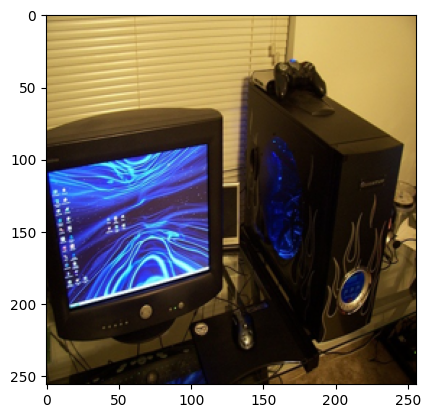

In [66]:
plt.subplot(1,1,1)
plt.imshow(test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


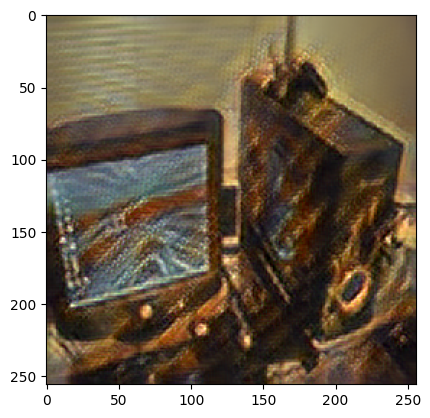

In [67]:

plt.imshow(op_image)